In [11]:
import seaborn as sns
import pandas as pd
import pickle
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from mpl_toolkits import mplot3d
from klepto.archives import dir_archive
import cv2
import time
from scipy.io import savemat

In [12]:
BEDFORMS = ['corals', 'canopy', 'rocks', 'dunes']
flow_speeds = ['fast', 'med', 'slow']
submergences = ['Deep', 'Intermed', 'Shallow']
colors = {'corals':'dodgerblue','canopy':'green', 'rocks':'orange', 'dunes':'brown'}

In [25]:
bed_idx = 0
flow_idx = 0
submergence_idx = 2
TEST = 2
BATCH_FRAMES =  75# for data acquired at 3 fp, total of 900, per subfolder 225 frames. 225/75 = 9


# SET the data variables
FLOW_SPEED = flow_speeds[flow_idx]
SUBMERGENCE = submergences[submergence_idx]
BEDFORM = BEDFORMS[bed_idx]

## PSD using 2D FFT

In [13]:
for i in range(1,5):
    # choose the data
    SUBFOLDER = i

    # source data folders
    data_foldername = "{}_{}Flow_{}H_test{}_subFolder{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST, SUBFOLDER)
    print(data_foldername)
    save_location =  "../FLIR_Camera"
    klepto_saved_data_origin = 'klepto_bulk_data_saves' 

    # retrive the saved data
    data_origin = os.path.join(save_location, klepto_saved_data_origin, data_foldername)
    bed_data ={BEDFORM:{}}
    tic = time.time()
    assert os.path.exists(data_origin) == True
    data = dir_archive(data_origin, {}, serialized=True, cached=False)
    bed_data[BEDFORM]['all_sx_maps'] = data['all_sx_maps']
    bed_data[BEDFORM]['all_sy_maps'] = data['all_sy_maps']
    del data
    toc = time.time()
    print("time taken to load the data  = ", toc-tic)

    NUM_FRAMES = bed_data[BEDFORM]['all_sx_maps'].shape[-1]

    # Accumulate the mean PSD of every BATCH_SIZE frames 
    if SUBFOLDER==1:
        s_hat_x_mag_mean = []
        s_hat_y_mag_mean = []

    for i in range(NUM_FRAMES//BATCH_FRAMES):    

        s_hat_x = np.fft.fft2(bed_data[BEDFORM]['all_sx_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], axes = ([0,1]))
        print(s_hat_x.shape)
        s_hat_x = np.fft.fftshift(s_hat_x)
        s_hat_x_mag = (np.log(np.abs(s_hat_x)))**2

        s_hat_y = np.fft.fft2(bed_data[BEDFORM]['all_sy_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], axes = ([0,1]))
        s_hat_y = np.fft.fftshift(s_hat_y) # DC content at the center
        s_hat_y_mag = (np.log(np.abs(s_hat_y)))**2

        s_hat_x_mag_mean.append(np.mean(s_hat_x_mag, axis = (2)))
        s_hat_y_mag_mean.append(np.mean(s_hat_y_mag, axis = (2)))

    del bed_data, s_hat_x, s_hat_y, s_hat_x_mag, s_hat_y_mag

corals_fastFlow_ShallowH_test2_subFolder1
time taken to load the data  =  15.274040222167969
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)
corals_fastFlow_ShallowH_test2_subFolder2
time taken to load the data  =  14.07341194152832
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)
corals_fastFlow_ShallowH_test2_subFolder3
time taken to load the data  =  14.281498670578003
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)
corals_fastFlow_ShallowH_test2_subFolder4
time taken to load the data  =  14.033730268478394
(1024, 1224, 75)
(1024, 1224, 75)
(1024, 1224, 75)


### Plot Power Spectral Density Ensemble Averages (slopes x,y)

In [14]:
FreqCompRows = np.fft.fftfreq(s_hat_x_mag_mean[0].shape[0],d=1)
FreqCompCols = np.fft.fftfreq(s_hat_x_mag_mean[0].shape[1],d=1)
FreqCompRows = np.fft.fftshift(FreqCompRows)
FreqCompCols = np.fft.fftshift(FreqCompCols)

R,C = np.meshgrid(FreqCompRows, FreqCompCols)
M,N = s_hat_x_mag_mean[0].shape[0:2]

In [15]:
sx_mean  = s_hat_x_mag_mean[0]
sy_mean  = s_hat_y_mag_mean[0]
instances = len(s_hat_x_mag_mean)
print("number of frames to average: ", instances)
for i in range(1,instances):
    sx_mean += s_hat_x_mag_mean[i]
    sy_mean += s_hat_y_mag_mean[i]
s_hat_x_mag_mean = sx_mean/instances
s_hat_y_mag_mean = sy_mean/instances

number of frames to average:  12


<Figure size 432x288 with 0 Axes>

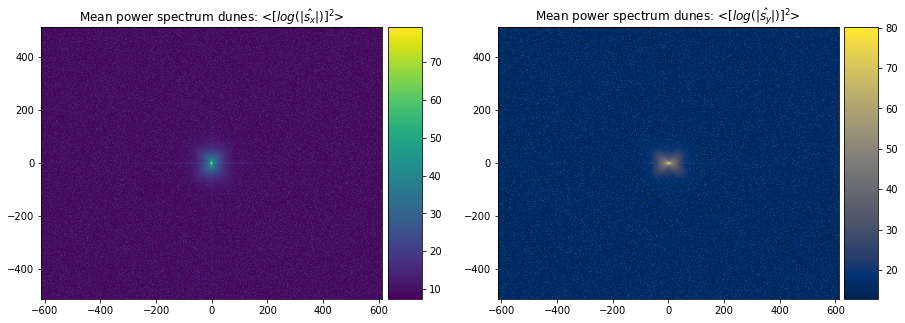

In [16]:
plt.figure()
fig, (ax0, ax1) = plt.subplots(1,2, figsize =(15, 5)) 

ax0.set_title("Mean power spectrum dunes: $\less [log(|\\hat{s_x}|)]^2 \greater$", fontsize=  12)
im0 = ax0.imshow(s_hat_x_mag_mean, cmap = plt.cm.viridis, aspect='auto'\
                ,extent=(-N // 2, N // 2, -M // 2, M // 2))#, vmin = 0, vmax = 255)
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="10%", pad=0.08)
cbar0 = plt.colorbar(im0, cax=cax0)


ax1.set_title("Mean power spectrum dunes: $\less [log(|\\hat{s_y}|)]^2 \greater$", fontsize=  12)
im1 = ax1.imshow(s_hat_y_mag_mean, cmap = plt.cm.cividis, aspect='auto'\
                , extent=(-N // 2, N // 2, -M // 2, M // 2)) # vmin = -5, vmax = 5, 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.08)
cbar1 = plt.colorbar(im1, cax=cax1)

filename = 'mean_PSD_{}_{}Flow_{}H_test{}.png'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
plt.savefig(save_dest)
plt.show()

<Figure size 432x288 with 0 Axes>

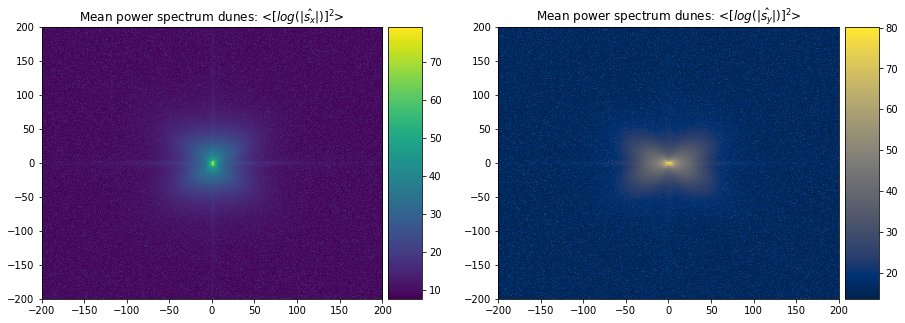

In [17]:
lim = 400
plt.figure()
fig, (ax0, ax1) = plt.subplots(1,2, figsize =(15, 5)) 

ax0.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{s_x}|)]^2 \greater$", fontsize=  12)
im0 = ax0.imshow(s_hat_x_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2] , cmap = plt.cm.viridis, aspect='auto'\
                ,extent=(-lim// 2, lim// 2, -lim // 2, lim // 2))#, vmin = 0, vmax = 255)
divider0 = make_axes_locatable(ax0)
cax0 = divider0.append_axes("right", size="10%", pad=0.08)
cbar0 = plt.colorbar(im0, cax=cax0)


ax1.set_title("Mean power spectrum {}: ".format(BEDFORM)+ "$\less [log(|\\hat{s_y}|)]^2 \greater$", fontsize=  12)
im1 = ax1.imshow(s_hat_y_mag_mean[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2], cmap = plt.cm.cividis, aspect='auto'\
                , extent=(-lim// 2, lim// 2, -lim // 2, lim // 2)) # vmin = -5, vmax = 5, 
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="10%", pad=0.08)
cbar1 = plt.colorbar(im1, cax=cax1)

filename = 'ZOOMED_mean_PSD_{}_{}Flow_{}H_test{}.png'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
plt.savefig(save_dest)
plt.show()

## Save the 3D FFT (for x,y,t) to visualize using Slicing in Matlab

In [26]:
NUM_SUBFOLDERS = 4
for i in range(1,5):

    # source data folders
    data_foldername = "{}_{}Flow_{}H_test{}_subFolder{}".format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST, SUBFOLDER)
    print(data_foldername)
    save_location =  "../FLIR_Camera"
    klepto_saved_data_origin = 'klepto_bulk_data_saves' 

    # retrive the saved data
    data_origin = os.path.join(save_location, klepto_saved_data_origin, data_foldername)
    bed_data ={BEDFORM:{}}
    tic = time.time()
    assert os.path.exists(data_origin) == True
    data = dir_archive(data_origin, {}, serialized=True, cached=False)
    bed_data[BEDFORM]['all_sx_maps'] = data['all_sx_maps']
    bed_data[BEDFORM]['all_sy_maps'] = data['all_sy_maps']
    del data
    toc = time.time()
    print("time taken to load the data  = ", toc-tic)

    NUM_FRAMES = bed_data[BEDFORM]['all_sx_maps'].shape[-1]

    # Accumulate the mean PSD of every BATCH_SIZE frames 
    instances  = NUM_FRAMES//BATCH_FRAMES
    for i in range(NUM_FRAMES//BATCH_FRAMES):    

        s_hat_x = np.fft.fftn(bed_data[BEDFORM]['all_sx_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], \
                              axes = ([0,1,2]))
        s_hat_x = np.fft.fftshift(s_hat_x)
        s_hat_x_PSD = (np.log(np.abs(s_hat_x)))**2

        s_hat_y = np.fft.fftn(bed_data[BEDFORM]['all_sy_maps'][:,:,i*BATCH_FRAMES:(i+1)*BATCH_FRAMES], \
                              axes = ([0,1,2]))
        s_hat_y = np.fft.fftshift(s_hat_y) # DC content at the center
        s_hat_y_PSD = (np.log(np.abs(s_hat_y)))**2
        
        if i==0:
            M,N,K = s_hat_x_PSD.shape
            lim = 80 # total window aroun 0 frequency    
            s_hat_x_mag = s_hat_x_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:] 
            s_hat_y_mag = s_hat_y_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:] 
        else:
            s_hat_x_mag += s_hat_x_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:] 
            s_hat_y_mag += s_hat_y_PSD[M//2 - lim//2:M//2 + lim//2, N//2 - lim//2:N//2 + lim//2,:]
    
    print("number of frames to average: ", instances)
    if SUBFOLDER==1:
        s_hat_x_mag_mean = s_hat_x_mag/instances
        s_hat_y_mag_mean = s_hat_y_mag/instances
    else:
        s_hat_x_mag_mean += s_hat_x_mag/instances
        s_hat_y_mag_mean += s_hat_y_mag/instances

    del bed_data, s_hat_x, s_hat_y, s_hat_x_PSD, s_hat_y_PSD, s_hat_x_mag, s_hat_y_mag

corals_fastFlow_ShallowH_test2_subFolder2
time taken to load the data  =  14.654050827026367
number of frames to average:  3
corals_fastFlow_ShallowH_test2_subFolder2
time taken to load the data  =  14.590938806533813
number of frames to average:  3
corals_fastFlow_ShallowH_test2_subFolder2
time taken to load the data  =  14.382222175598145
number of frames to average:  3
corals_fastFlow_ShallowH_test2_subFolder2
time taken to load the data  =  13.118132591247559
number of frames to average:  3


In [27]:
s_hat_x_mag_mean = s_hat_x_mag_mean/NUM_SUBFOLDERS 
s_hat_y_mag_mean = s_hat_y_mag_mean/NUM_SUBFOLDERS
print(s_hat_x_mag_mean.shape)

(80, 80, 75)


In [28]:
FreqCompRows = np.fft.fftfreq(s_hat_x_mag_mean.shape[0],d=1)
FreqCompCols = np.fft.fftfreq(s_hat_x_mag_mean.shape[1],d=1)
FreqCompVert = np.fft.fftfreq(s_hat_x_mag_mean.shape[2],d=1)
FreqCompRows = np.fft.fftshift(FreqCompRows)
FreqCompCols = np.fft.fftshift(FreqCompCols)
FreqCompVert = np.fft.fftshift(FreqCompVert)

R,C,V = np.meshgrid(FreqCompRows, FreqCompCols, FreqCompVert)
print(s_hat_x_mag_mean.shape, FreqCompRows.shape, FreqCompCols.shape, FreqCompVert.shape)

(80, 80, 75) (80,) (80,) (75,)


In [29]:
dic = {"R":R,"C":C,"V":V \
         ,"FreqCompRows":FreqCompRows, "FreqCompCols":FreqCompCols, "FreqCompVert":FreqCompVert\
        ,"s_hat_x_mag_mean":s_hat_x_mag_mean, "s_hat_y_mag_mean":s_hat_y_mag_mean ,'BEDFORM':BEDFORM}
filename = 'ZOOMED_mean_3DFFT_{}_{}Flow_{}H_test{}.mat'.format(BEDFORM, FLOW_SPEED, SUBMERGENCE, TEST)
save_dest = os.path.join(save_location, klepto_saved_data_origin, filename)
savemat(save_dest,dic)